# Step 1: Dataset Selection

[Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing) dataset from UCI's machine learning repository was selected. The dataset belongs to regulated domain of credit.

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import disparate_impact_ratio, statistical_parity_difference
from aif360.sklearn.preprocessing import Reweighing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'
pip install 'aif360[FairAdapt]'
pip install 'aif360[LFR]'


Load dataset - online

In [ ]:
# import dataset 
bank_marketing = fetch_ucirepo(id=222) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
print(bank_marketing.metadata) 
print(bank_marketing.variables)

In [ ]:
# convert to dataframe
df = X.copy()
df['y'] = y
df.dropna(axis=0, inplace=True, ignore_index=True)
df.head()

Load dataset - offline

In [2]:
# import dataset 
df = pd.read_csv('bank-full.csv')
df.dropna(axis=0, inplace=True, ignore_index=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,33,admin.,married,tertiary,no,882,no,no,telephone,21,oct,39,1,151,3,failure,no
1,42,admin.,single,secondary,no,-247,yes,yes,telephone,21,oct,519,1,166,1,other,yes
2,33,services,married,secondary,no,3444,yes,no,telephone,21,oct,144,1,91,4,failure,yes
3,36,management,married,tertiary,no,2415,yes,no,telephone,22,oct,73,1,86,4,other,no
4,36,management,married,tertiary,no,0,yes,no,telephone,23,oct,140,1,143,3,failure,yes


# Step 2: Explore the Dataset


Examine observation and variable count

In [3]:
print(df.shape)

(7842, 17)


Create 2nd dependent variable: Credit Eligibility

In [4]:
df['balance'].value_counts(), df['default'].value_counts()

(balance
 0        432
 1         20
 2         20
 4         17
 5         17
         ... 
 1128       1
 1675       1
 1204       1
 12980      1
 1680       1
 Name: count, Length: 3090, dtype: int64,
 default
 no     7786
 yes      56
 Name: count, dtype: int64)

In [5]:
# create credit eligibility 
df['credit'] = df.apply(lambda row: 'yes' if row['balance'] > 0 and row['default'] == 'no' else 'no', axis=1)
df['credit'].value_counts()

credit
yes    6921
no      921
Name: count, dtype: int64

Create subgroup for protected classes

In [6]:
# sort dataset by protected class subgroups
df['age_group'] = (df['age'] <= 40).astype(int)
df['marital_group'] = (df['marital'] == 'married').astype(int)

In [7]:
# drop original age and martial columns
df.drop(['age', 'marital'], axis=1, inplace=True)

Visualize frequency of subgroups in function to depedent variables

In [8]:
# age group to subscription
ay=pd.crosstab(df['age_group'], df['y'])
ay

y,no,yes
age_group,,
0,2468,794
1,3588,992


In [9]:
# age group to eligibility
ac=pd.crosstab(df['age_group'], df['credit'])
ac

credit,no,yes
age_group,,
0,420,2842
1,501,4079


In [10]:
# marital status to subscription
my=pd.crosstab(df['marital_group'], df['y'])
my

y,no,yes
marital_group,,
0,2535,806
1,3521,980


In [11]:
# age group to eligibility
mc=pd.crosstab(df['marital_group'], df['credit'])
mc

credit,no,yes
marital_group,,
0,367,2974
1,554,3947


In [12]:
def p(data, title, xlabel, xtick_labels):
    data.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('count')
    plt.xticks(ticks=range(len(xtick_labels)), labels=xtick_labels, rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

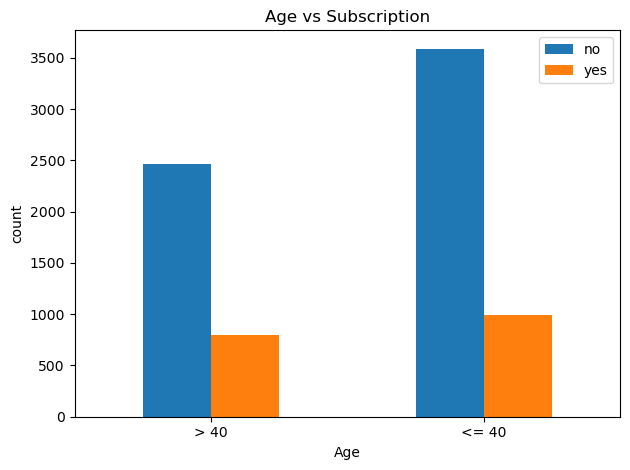

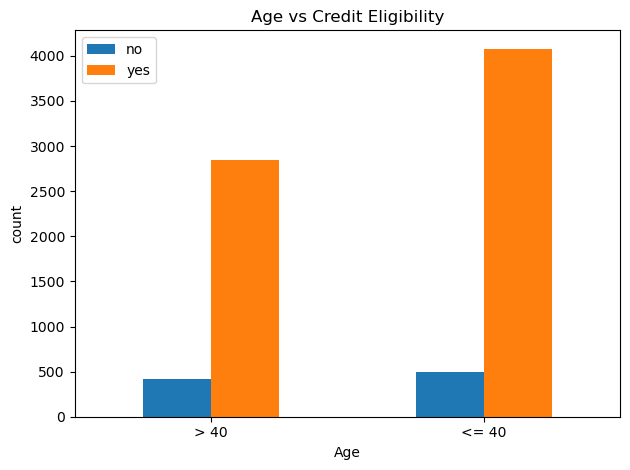

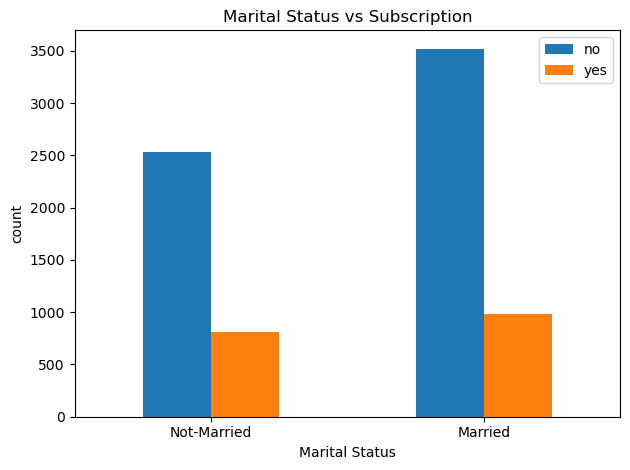

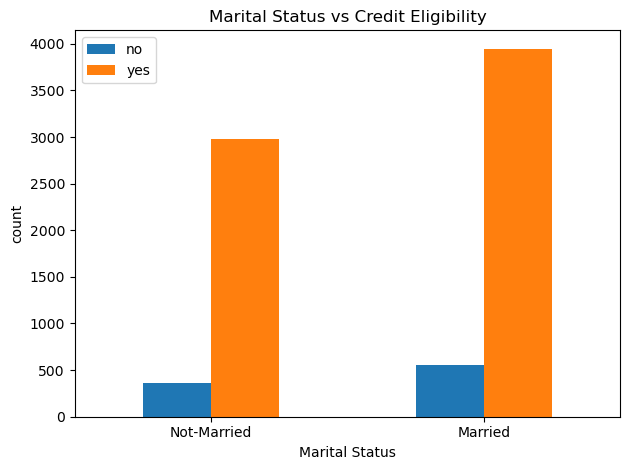

In [13]:
# print frequency bar graph for members in subgroups
p(ay, 'Age vs Subscription', 'Age', ['> 40', '<= 40'])
p(ac, 'Age vs Credit Eligibility', 'Age', ['> 40', '<= 40'])
p(my, 'Marital Status vs Subscription', 'Marital Status', ['Not-Married', 'Married'])
p(mc, 'Marital Status vs Credit Eligibility', 'Marital Status', ['Not-Married', 'Married'])

Ordinal encode data

In [14]:
enc = OrdinalEncoder()
encoded=enc.fit_transform(df)
encoded=pd.DataFrame(encoded, columns=df.columns)
encoded.head()

,job,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,credit,age_group,marital_group
0,0.0,2.0,0.0,1155.0,0.0,0.0,1.0,20.0,10.0,34.0,0.0,147.0,2.0,0.0,0.0,1.0,1.0,1.0
1,0.0,1.0,0.0,180.0,1.0,1.0,1.0,20.0,10.0,512.0,0.0,162.0,0.0,1.0,1.0,0.0,0.0,0.0
2,7.0,1.0,0.0,2366.0,1.0,0.0,1.0,20.0,10.0,139.0,0.0,87.0,3.0,0.0,1.0,1.0,1.0,1.0
3,4.0,2.0,0.0,2051.0,1.0,0.0,1.0,21.0,10.0,68.0,0.0,82.0,3.0,1.0,0.0,1.0,1.0,1.0
4,4.0,2.0,0.0,326.0,1.0,0.0,1.0,22.0,10.0,135.0,0.0,139.0,2.0,0.0,1.0,0.0,1.0,1.0


# Step 3: Fairness Metric Selection and Mitigating Bias with PreProcessing Algorithms


Compute fairness metrics before bias mitigation

In [15]:
# Age - Subscription
ay_BL = BinaryLabelDataset(
    df=encoded,
    label_names=['y'],
    protected_attribute_names=['age_group']
)
ay_BL_metric = ClassificationMetric(ay_BL, ay_BL, 
    unprivileged_groups=[{'age_group': 0}], 
    privileged_groups=[{'age_group': 1}]
)

In [16]:
# Age - Credit
ac_BL = BinaryLabelDataset(
    df=encoded,
    label_names=['credit'],
    protected_attribute_names=['age_group']
)
ac_BL_metric = ClassificationMetric(ac_BL, ac_BL, 
    unprivileged_groups=[{'age_group': 0}], 
    privileged_groups=[{'age_group': 1}]
)

In [17]:
# Marital - Subscription
my_BL = BinaryLabelDataset(
    df=encoded,
    label_names=['y'],
    protected_attribute_names=['marital_group']
)
my_BL_metric = ClassificationMetric(my_BL, my_BL, 
    unprivileged_groups=[{'marital_group': 0}], 
    privileged_groups=[{'marital_group': 1}]
)

In [18]:
# Marital - Credit
mc_BL = BinaryLabelDataset(
    df=encoded,
    label_names=['credit'],
    protected_attribute_names=['marital_group']
)
mc_BL_metric = ClassificationMetric(mc_BL, mc_BL, 
    unprivileged_groups=[{'marital_group': 0}], 
    privileged_groups=[{'marital_group': 1}]
)

In [19]:
# print results
print('Pre-weigh')
print('Age - Subscription (Disparate Impact):', ay_BL_metric.disparate_impact())
print('Age - Subscription (Statistical Parity Difference):', ay_BL_metric.statistical_parity_difference())

print('Age - Credit (Disparate Impact):', ac_BL_metric.disparate_impact())
print('Age - Credit (Statistical Parity Difference):', ac_BL_metric.statistical_parity_difference())

print('Marital - Subscription (Disparate Impact):', my_BL_metric.disparate_impact())
print('Marital - Subscription (Statistical Parity Difference):', my_BL_metric.statistical_parity_difference())

print('Marital - Credit (Disparate Impact):', mc_BL_metric.disparate_impact())
print('Marital - Credit (Statistical Parity Difference):', mc_BL_metric.statistical_parity_difference())

Pre-weigh
Age - Subscription (Disparate Impact): 1.123803425565159
Age - Subscription (Statistical Parity Difference): 0.026815065100575908
Age - Credit (Disparate Impact): 0.9782545793538978
Age - Credit (Statistical Parity Difference): -0.019366718518657344
Marital - Subscription (Disparate Impact): 1.1080044469149528
Marital - Subscription (Statistical Parity Difference): 0.023515742718652227
Marital - Credit (Disparate Impact): 1.0150942672238952
Marital - Credit (Statistical Parity Difference): 0.013236408072142769


Reweigh dataset as a function of subscription variable

In [20]:
# sample reweigh dataset
X = encoded.drop(['y'], axis=1)
X.set_index(['age_group', 'marital_group'], inplace=True)
y = encoded['y']
rw = Reweighing(prot_attr=['age_group', 'marital_group'])
_, weight = rw.fit_transform(X, y)
df_w = encoded.copy()
df_w['weight'] = weight

Compute fairness metrics after bias mitigation

In [21]:
# Age - Subscription
ay_W = BinaryLabelDataset(
    df=df_w,
    label_names=['y'],
    protected_attribute_names=['age_group'],
    instance_weights_name=['weight']
)
ay_W_metric = ClassificationMetric(ay_W, ay_W, 
    unprivileged_groups=[{'age_group': 0}], 
    privileged_groups=[{'age_group': 1}]
)

In [22]:
# Age - Credit
ac_W = BinaryLabelDataset(
    df=df_w,
    label_names=['credit'],
    protected_attribute_names=['age_group'],
    instance_weights_name=['weight']
)
ac_W_metric = ClassificationMetric(ac_W, ac_W, 
    unprivileged_groups=[{'age_group': 0}], 
    privileged_groups=[{'age_group': 1}]
)

In [23]:
# Marital - Subscription
my_W = BinaryLabelDataset(
    df=df_w,
    label_names=['y'],
    protected_attribute_names=['marital_group'],
    instance_weights_name=['weight']
)
my_W_metric = ClassificationMetric(my_W, my_W, 
    unprivileged_groups=[{'marital_group': 0}], 
    privileged_groups=[{'marital_group': 1}]
)

In [24]:
# Marital - Credit
mc_W = BinaryLabelDataset(
    df=df_w,
    label_names=['credit'],
    protected_attribute_names=['marital_group'],
    instance_weights_name=['weight']
)
mc_W_metric = ClassificationMetric(mc_W, mc_W, 
    unprivileged_groups=[{'marital_group': 0}], 
    privileged_groups=[{'marital_group': 1}]
)

In [25]:
# print results
print('Post-weigh')
print('Age - Subscription (Disparate Impact):', ay_W_metric.disparate_impact())
print('Age - Subscription (Statistical Parity Difference):', ay_W_metric.statistical_parity_difference())

print('Age - Credit (Disparate Impact):', ac_W_metric.disparate_impact())
print('Age - Credit (Statistical Parity Difference):', ac_W_metric.statistical_parity_difference())

print('Marital - Subscription (Disparate Impact):', my_W_metric.disparate_impact())
print('Marital - Subscription (Statistical Parity Difference):', my_W_metric.statistical_parity_difference())

print('Marital - Credit (Disparate Impact):', mc_W_metric.disparate_impact())
print('Marital - Credit (Statistical Parity Difference):', mc_W_metric.statistical_parity_difference())

Post-weigh
Age - Subscription (Disparate Impact): 0.9999999999999999
Age - Subscription (Statistical Parity Difference): -2.7755575615628914e-17
Age - Credit (Disparate Impact): 0.9767550783564906
Age - Credit (Statistical Parity Difference): -0.020706696714963058
Marital - Subscription (Disparate Impact): 1.0000000000000002
Marital - Subscription (Statistical Parity Difference): 2.7755575615628914e-17
Marital - Credit (Disparate Impact): 1.014016614693318
Marital - Credit (Statistical Parity Difference): 0.012291941280142993


# Step 4: Mitigating Bias


Split train test data

In [26]:
# split into training and testing
X = encoded.drop(['y'], axis=1)
y = encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train linear classifier using original data and as a function of subscription variable

In [27]:
# linear regression
pre_model = LinearRegression()
pre_model.fit(X_train, y_train)
pre_y_pred = pre_model.predict(X_test)

In [28]:
# sort prediction into yes or no based on threshold
threshold = 0.5
pre_df = X_test.copy()
pre_df['y_pred'] = (pre_y_pred > threshold).astype(float)

Compute fairness metric on results

In [29]:
# Age - Subscription
pre_ay_BL = BinaryLabelDataset(
    df=pre_df,
    label_names=['y_pred'],
    protected_attribute_names=['age_group'],
)
pre_ay_BL_metric = ClassificationMetric(pre_ay_BL, pre_ay_BL, 
    unprivileged_groups=[{'age_group': 0}], 
    privileged_groups=[{'age_group': 1}]
)

In [30]:
# Age - Subscription
pre_my_BL = BinaryLabelDataset(
    df=pre_df,
    label_names=['y_pred'],
    protected_attribute_names=['marital_group'],
)
pre_my_BL_metric = ClassificationMetric(pre_my_BL, pre_my_BL, 
    unprivileged_groups=[{'marital_group': 0}], 
    privileged_groups=[{'marital_group': 1}]
)

In [31]:
# print results
print('Pre-weigh, Linear Regression')
print('Age - Subscription (Disparate Impact):', pre_ay_BL_metric.disparate_impact())
print('Age - Subscription (Statistical Parity Difference):', pre_ay_BL_metric.statistical_parity_difference())

print('Marital - Subscription (Disparate Impact):', pre_my_BL_metric.disparate_impact())
print('Marital - Subscription (Statistical Parity Difference):', pre_my_BL_metric.statistical_parity_difference())

Pre-weigh, Linear Regression
Age - Subscription (Disparate Impact): 1.3185847775736763
Age - Subscription (Statistical Parity Difference): 0.04656239056846037
Marital - Subscription (Disparate Impact): 1.067005516642906
Marital - Subscription (Statistical Parity Difference): 0.010797798487708898


Create weights for test values

In [32]:
_, lr_weight = rw.fit_transform(
    X_train.set_index(['age_group', 'marital_group'], inplace=False),
    y_train
)

Train linear classifier using weighed data and as a function of subscription variable

In [33]:
# linear regression
post_model = LinearRegression()
post_model.fit(X_train, y_train, sample_weight=lr_weight)
post_y_pred = post_model.predict(X_test)

In [34]:
# sort prediction into yes or no based on threshold
threshold = 0.5
post_df = X_test.copy()
post_df['y_pred'] = (post_y_pred > threshold).astype(float)

Compute fairness metric on results

In [35]:
# Age - Subscription
post_ay_W = BinaryLabelDataset(
    df=post_df,
    label_names=['y_pred'],
    protected_attribute_names=['age_group'],
)
post_ay_W_metric = ClassificationMetric(post_ay_W, post_ay_W, 
    unprivileged_groups=[{'age_group': 0}], 
    privileged_groups=[{'age_group': 1}]
)

In [36]:
# Age - Subscription
post_my_W = BinaryLabelDataset(
    df=post_df,
    label_names=['y_pred'],
    protected_attribute_names=['marital_group'],
)
post_my_W_metric = ClassificationMetric(post_my_W, post_my_W, 
    unprivileged_groups=[{'marital_group': 0}], 
    privileged_groups=[{'marital_group': 1}]
)

In [37]:
# print results
print('Post-weigh, Linear Regression')
print('Age - Subscription (Disparate Impact):', post_ay_W_metric.disparate_impact())
print('Age - Subscription (Statistical Parity Difference):', post_ay_W_metric.statistical_parity_difference())

print('Marital - Subscription (Disparate Impact):', post_my_W_metric.disparate_impact())
print('Marital - Subscription (Statistical Parity Difference):', post_my_W_metric.statistical_parity_difference())

Post-weigh, Linear Regression
Age - Subscription (Disparate Impact): 1.227448996796493
Age - Subscription (Statistical Parity Difference): 0.033742433590688514
Marital - Subscription (Disparate Impact): 1.0039708190968695
Marital - Subscription (Statistical Parity Difference): 0.0006442719726708901
